In [1]:
import os
import copy
import time
import asyncio
import warnings
import logging

from pathlib import Path

import numpy as np
from astropy.io import fits

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter
from astropy.modeling import models, fitting


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]

#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

%matplotlib inline

In [2]:
import wget

In [3]:
from lsst.ts import salobj
from lsst.ts.standardscripts.auxtel.attcs import ATTCS
import asyncio

In [ ]:
attcs = ATTCS()
cam = salobj.Remote(attcs.domain, "GenericCamera", 1)

In [ ]:
await asyncio.gather(attcs.start_task, cam.start_task) 

## Declare target

In [ ]:
# Declare target name
target_name='ksiPup'

In [ ]:
# Print Hexapod Current position (given by last successful command)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.aget(timeout=10)
print('Current Hexapod position from evt_positionUpdate: \n x= {}, \n y= {}, \n z= {}, \n U= {}, \n V= {}'
      .format(curr_hex_pos.positionX, curr_hex_pos.positionY, curr_hex_pos.positionZ, curr_hex_pos.positionU, curr_hex_pos.positionV))

In [ ]:
hex_X, hex_Y, hex_Z, hex_U, hex_V, hex_R = [-4.350, 0.100, 0.518, 0.350, 0.220, 0.000]

hex_X, hex_Y, hex_Z, hex_U, hex_V, hex_R = [-4.350, 0.100, 0.518-0.060, 0.350, 0.220, 0.000]

print('Command to Hexapod in-focus position')
await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, 
                                                   y=hex_Y,
                                                   z=hex_Z, 
                                                   u=hex_U, 
                                                   v=hex_V)

In [ ]:
dz=1.5
focus_offset = 70.18853183/1e3/4.2
expTime=30.0
print(focus_offset)

In [ ]:
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=0.)

In [ ]:
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=focus_offset)
try:
    curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)
except asyncio.TimeoutError:
    print("Timedout")

In [ ]:
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="x", offset=-0.6881088203816793)
try:
    curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)
except asyncio.TimeoutError:
    print("Timedout")

In [ ]:
await cam.cmd_startLiveView.set_start(expTime=0.5)

In [ ]:
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="m1", offset=2e3)

In [ ]:
try:
    await cam.cmd_stopLiveView.start()
except salobj.AckError:
    print("ack error")

# Intrafocal hexapod setting - offsets -0.5mm from central focus value above

print('Move to intrafocal position')
# await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
#                                              z=hex_Z-dz, u=hex_U, v=hex_V)
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=-dz+focus_offset)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

print('Take intrafocal image')
cam.evt_endReadout.flush()

await cam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName=target_name+'_intra')

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=1)

print(intra_endron.imageName)

# Extrafocal hexapod setting
print('Move to extra-focal hexapod position')
# await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
#                                                      z=hex_Z+dz, u=hex_U, v=hex_V)
attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=dz+focus_offset)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

# r.evt_endReadout.flush()
print('Take extra-focal image')
cam.evt_endReadout.flush()
await cam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName=target_name+'_extra')

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=1)

print(extra_endron.imageName)

try:
    await cam.cmd_startLiveView.set_start(expTime=0.5)
except salobj.AckError:
    print("ack error")

attcs.athexapod.evt_positionUpdate.flush()
await attcs.ataos.cmd_applyAxisOffset.set_start(axis="z", offset=focus_offset)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.next(flush=False, timeout=30)

intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f"============")
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')
print(f"============")

In [4]:
intra_fname="1579841532-ksiPup_intra-0-1.fits"
extra_fname="1579841576-ksiPup_extra-0-1.fits"

In [11]:
intra_fname="1579841642-ksiPup_intra-0-1.fits"
extra_fname="1579841686-ksiPup_extra-0-1.fits"

In [18]:
intra_fname="1579841797-ksiPup_intra-0-1.fits"
extra_fname="1579841841-ksiPup_extra-0-1.fits"

In [25]:
intra_fname="1579842744-ksiPup_intra-0-1.fits"
extra_fname="1579842788-ksiPup_extra-0-1.fits"

In [32]:
intra_fname="1579842868-ksiPup_intra-0-1.fits"
extra_fname="1579842912-ksiPup_extra-0-1.fits"

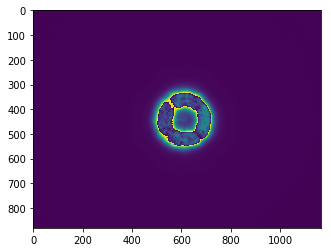

In [33]:
# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

In [34]:
# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=300
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

1 1
Creating stamps of centroid [y,x] = [440,610] with a side length of 150 pixels


In [35]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

In [36]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)



Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


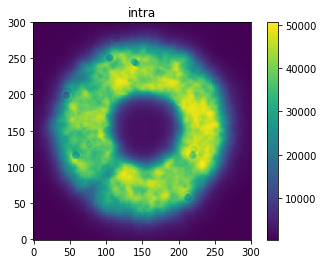

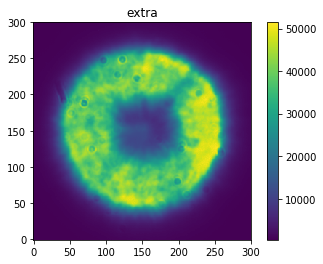

Extra-focal filename: 1579842912-ksiPup_extra-0-1.fits
Intra-focal filename: 1579842868-ksiPup_intra-0-1.fits


In [37]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

[-126.09365654   66.14542317   82.8435953    12.64637382   10.33499827
  -57.63487156    8.15836802   -1.33154177   -4.21729599  -11.76682961
  -15.04726294  -37.27616419   19.18540831   -2.67571626    8.08788814
   -1.71718465   14.93556534    9.40664636  -12.09322897]


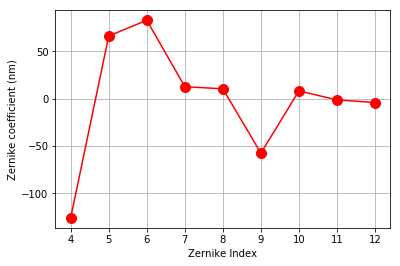

In [38]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

[-98.75060338 -51.82782847 -10.5584256  -29.09182031   9.82635674
 -52.91966212 -14.6803011   -4.27931605   3.24236428  -9.88120531
 -25.04192312 -14.38994916  16.61942512   4.68815711   5.35383145
  -0.31298702  16.88189921  -4.06566223 -13.88739268]


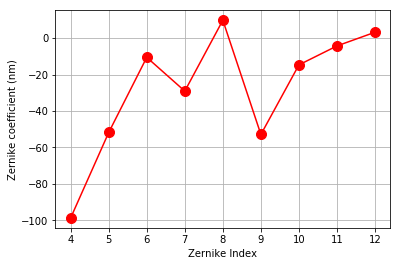

In [31]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

[  18.80135554   54.65528724 -102.86250022  -40.24817116   21.97368219
  -51.07265232   27.57068418  -28.38799421   -4.49444893  -23.60013168
  -22.02536388    6.10749288    7.1039884     1.91410387   -5.9701759
   -9.92516531   -2.18874857   -7.48111573   -4.34773658]


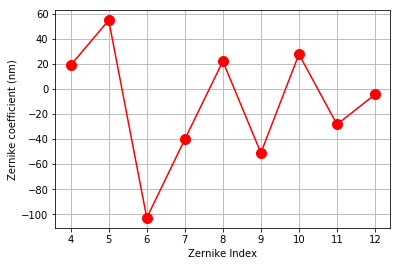

In [17]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

In [ ]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

In [ ]:
algo.runIt(inst,I1,I2,'onAxis')
print(algo.zer4UpNm)
plots.plotZer(algo.zer4UpNm[0:9],'nm')

In [ ]:
-90.14225547/131